# MSP Simulation Example
# Simulation based on state equations

## Sample Circuit

<img src="Fig1_StateEq_ASMG.png" width="500" align="left">

$R_1$=$1 \Omega$, $R_3$=$1 \Omega$  
$L_1$=$20 mH$, $L_2$=$100 mH$, $L_3$=$50 mH$  
$V_{in}(t)$=$10 V sin(\omega t)$

## Circuit and Simulation Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(sign=' ')

# Circuit parameters:
R1 = 1.0
R3 = 2.0
L1 = 20.0e-3
L2 = 100.0e-3
L3 = 50.0e-3
Emax = 10.0

# Simulation parameters
# Total simulation time
T_total = 0.05
# Simulaiton time step 
Ts = 5.0e-6
# Number of simulation time steps
npoint = int(np.round(T_total/Ts))

print('Total simulation time: ' + str(T_total))
print('Simulation time step: ' + str(Ts))

Total simulation time: 0.05
Simulation time step: 5e-06


## Automated State Model Generation Algorithm 

### Selection of branches

<img src="Fig2_StateEq_ASMG.png" width="500" align="left">

### Branch model

In [2]:
# Number of branches
Nbr = 3

# Branch model
rbr = np.array([ [R1,  0,  0],
                 [0,  0,  0],
                 [0,  0,  R3]])

Lbr = np.array([ [L1,  0,  0],
                 [0,  L2,  0],
                 [0,  0,  L3]])

# Reciprocal capacitance
Pbr = np.array([ [0,  0,  0],
                 [0,  0,  0],
                 [0,  0,  0]])

M = np.array([ [0 ],
               [0 ],
               [0 ]])

# Basic loop matrix
Bb = np.array([ [-1,  1,  0],
                [0,  -1,  1]])

Bbt = Bb.transpose()

### Matrices for state equation

In [3]:
rx = np.matmul(np.matmul(Bb,rbr),Bbt)
Lx = np.matmul(np.matmul(Bb,Lbr),Bbt)
pLx = 0
Px = np.matmul(np.matmul(Bb,Pbr),M)

In [4]:
Lx_inv = np.linalg.inv(Lx)

# State space matrices for the case with all branches without a capacitance
# Matrix A
A = np.matmul(-Lx_inv,(rx+pLx))
# Matrix B
B = np.matmul(-Lx_inv,Bb)
# Matrix C
tmp = np.matmul(rbr,Bbt) - np.matmul(np.matmul(Lbr, Bbt), np.matmul(Lx_inv, rx))
C = np.concatenate((Bbt, tmp), axis = 0)
# Matrix D
(tmp_m, tmp_n) = np.shape(np.matmul(np.matmul(Lbr, Bbt), np.matmul(Lx_inv, Bb)))
tmp1 = np.zeros((2*Nbr-tmp_m, tmp_n))
tmp2 = np.eye(tmp_m, tmp_n) - np.matmul(np.matmul(Lbr, Bbt), np.matmul(Lx_inv, Bb))
D = np.concatenate((tmp1, tmp2), axis = 0)

# Number of state variables
(N, tmp) = np.shape(A)
print('Number of state variables N:\n', N)

print('\nA: \n' + str(A))
print('\nB: \n' + str(B))
print('\nC: \n' + str(C))
print('\nD: \n' + str(D))

# Discretization of state space matrices 
# Numerical integration: Euler Forward
Ad = np.identity(N) + A*Ts
Bd = B*Ts

Number of state variables N:
 2

A: 
[[-18.75 -25.  ]
 [-12.5  -30.  ]]

B: 
[[ 18.75  -6.25 -12.5 ]
 [ 12.5    2.5  -15.  ]]

C: 
[[-1.     0.   ]
 [ 1.    -1.   ]
 [ 0.     1.   ]
 [-0.625  0.5  ]
 [-0.625  0.5  ]
 [-0.625  0.5  ]]

D: 
[[ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.625  0.125  0.25 ]
 [ 0.625  0.125  0.25 ]
 [ 0.625  0.125  0.25 ]]


### Simulation loop 

In [5]:
# Create state vector
x = np.zeros((N,npoint))

# Initial state
# Current values through the branches (inductances) = 0

# Time loop
for i in np.arange(1,npoint):
    # Input vector u = [jbr; ebr];
    Ebr_1 = Emax*np.sin(2*np.pi*60*i*Ts)
    u = np.array([ [Ebr_1],
                   [0],
                   [0]])

    # state vector
    x_hist = np.array([ [ x[0,i-1] ],
                        [ x[1,i-1]] ])
    x_i = np.matmul(Ad, x_hist) + np.matmul(Bd, u)
    x[0,i] = x_i[0,0]
    x[1,i] = x_i[1,0]

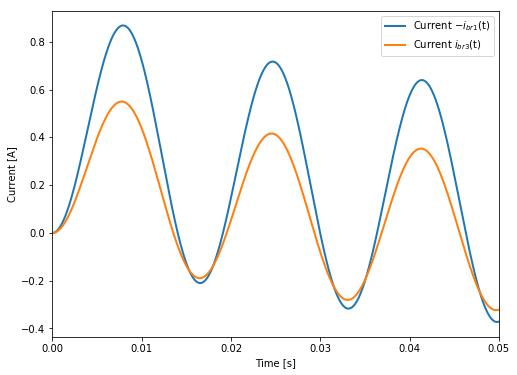

In [6]:
t = np.arange(0, npoint)*Ts
plt.figure(figsize=(8,6))
plt.xlabel('Time [s]')
plt.ylabel('Current [A]')
plt.plot(t,x[0,:], t, x[1,:], linewidth=2)
plt.xlim([0, (npoint-1)*Ts])
plt.legend(['Current $-i_{br1}$(t)', 'Current $i_{br3}$(t)'])
plt.show()